# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared quantum policy and joint quantum critic.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import cirq
import functools as ft
from datetime import datetime

In [21]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [22]:
output_dir = Path('./output/')
root_dir = output_dir/'coingame_maa2c_quantum_newencoding'
root_dir.expanduser().mkdir(parents=True, exist_ok=True)

checkpoint_dir = root_dir / 'checkpoints'


metrics_file = root_dir / 'metrics.json'
model_actor_checkpoint_file = checkpoint_dir / 'actor' / 'cp-{datetime}.ckpt'
model_critic_checkpoint_file = checkpoint_dir / 'critic' / 'cp-{datetime}.ckpt'

In [23]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [24]:
def map_observable_to_vector(obs: tf.Tensor) -> tf.Tensor:
    i = -tf.range(obs.shape[-1], dtype=obs.dtype) # Power of 2 that represents the column within the grid.
    return tf.math.reduce_sum(obs * (2**i), axis=-1)

def generate_model_CoinGame2_actor_quantum(
    n_layers,
    beta = 1.0,
    name=None,
    ):
    """Single-agent variant of hybrid quantum actor for CoinGame.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,3,3)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(d_qubits)
    
    # Generate observables.
    observables = eqmarl.make_observables_CoinGame2(qubits)

    # Define quantum layer.
    qlayer = eqmarl.HybridVariationalEncodingPQC(
        qubits=qubits, 
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        # squash_activation='tanh',
        squash_activation='arctan',
        encoding_layer_cls=eqmarl.ParameterizedRotationLayer_RxRyRz,
        )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(input_size,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Reshape((*obs_shape,)), # Reshape to matrix grid.
                keras.layers.Lambda(lambda x: map_observable_to_vector(x)), # converts (4,3,3) into (4,3)
                ], name="input-preprocess"),
            qlayer, # Hybrid quantum layer.
            keras.Sequential([
                eqmarl.RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                keras.layers.Softmax(),
                ], name='observables-policy')
        ], name=name)
    return model

def generate_model_CoinGame2_critic_quantum_partite(
    n_agents,
    n_layers,
    beta = 1.0,
    squash_activation = 'linear', # linear, arctan/atan, tanh
    name=None,
    ):
    """eQMARL variant of hybrid joint quantum critic for CoinGame.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,3,3)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(n_agents * d_qubits)

    # Observables is joint Pauli product across all qubits.
    observables = [ft.reduce(lambda x,y: x*y, [cirq.Z(q) for q in qubits])]

    # Define quantum layer.
    qlayer = eqmarl.HybridPartiteVariationalEncodingPQC(
        qubits=qubits, 
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        squash_activation=squash_activation,
        encoding_layer_cls=eqmarl.ParameterizedRotationLayer_RxRyRz,
        )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(n_agents, input_size), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Reshape((n_agents, *obs_shape)), # Reshape to matrix grid.
                keras.layers.Lambda(lambda x: map_observable_to_vector(x)), # converts (n_agents,4,3,3) into (n_agents,4,3)
                ], name="input-preprocess"),
            qlayer,
            keras.Sequential([
                eqmarl.RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                ], name='observables-value')
        ], name=name)
    return model






# Quantum shared actor.
model_actor = generate_model_CoinGame2_actor_quantum(
    n_layers=5,
    name=f"actor-quantum-shared",
    )
optimizer_actor = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]

model_actor.build((None, observation_dim))
model_actor.summary()


# Quantum joint critic.
model_critic = generate_model_CoinGame2_critic_quantum_partite(
    n_agents=n_agents,
    n_layers=5,
    name=f"critic-quantum-joint",
    )
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 3)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 4)                4         
 ial)                                                            
                                                                 
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________
Model: "critic-quantum-joint"
__________________

In [25]:
model_actor.trainable_variables

[<tf.Variable 'w_var:0' shape=(6, 4, 3) dtype=float32, numpy=
 array([[[2.1289568 , 1.086458  , 2.8551705 ],
         [0.4196958 , 3.0784223 , 3.073844  ],
         [1.5152    , 1.9734648 , 1.568913  ],
         [0.1094216 , 1.4695016 , 2.8197293 ]],
 
        [[0.4624001 , 0.3159113 , 2.2901466 ],
         [0.76385427, 0.7234581 , 1.0214728 ],
         [1.7312719 , 2.3290105 , 2.2823973 ],
         [0.8550868 , 0.23551287, 2.240696  ]],
 
        [[0.17377314, 1.2697589 , 2.3465934 ],
         [1.6538261 , 0.840123  , 1.2419088 ],
         [2.5181332 , 2.0798094 , 2.4148262 ],
         [2.1562603 , 3.003521  , 0.77530974]],
 
        [[1.6154807 , 1.8079364 , 0.77588683],
         [0.9062486 , 2.7957883 , 2.1348436 ],
         [2.9136493 , 2.3928978 , 1.9024463 ],
         [0.62512493, 0.78453755, 0.6785899 ]],
 
        [[0.9248369 , 0.2629399 , 2.3257658 ],
         [2.8513775 , 0.7102683 , 0.54034775],
         [0.6423073 , 3.0353503 , 1.988192  ],
         [2.6033068 , 1.7715352 ,

In [18]:
# model_actor.load_weights('output/coingame_maa2c_quantum_newencoding/checkpoints/actor/checkpoint')
latest_actor = tf.train.latest_checkpoint(model_actor_checkpoint_file.parent)
model_actor.load_weights(latest_actor)

model_actor.trainable_variables

[<tf.Variable 'w_var:0' shape=(6, 4, 3) dtype=float32, numpy=
 array([[[ 1.9399598 ,  0.38182324,  2.4823217 ],
         [ 0.10603759,  0.7907433 ,  2.5515277 ],
         [ 2.9185586 ,  1.3676196 , -0.07388511],
         [ 0.73272127, -0.4980315 , -0.5943343 ]],
 
        [[ 1.2838725 ,  1.8347483 ,  0.5385624 ],
         [ 1.7391334 ,  1.5680968 ,  1.1512824 ],
         [ 0.045286  ,  0.9718599 ,  0.8339476 ],
         [ 0.95334107,  2.0092053 ,  2.2656465 ]],
 
        [[ 3.1357517 ,  1.2426089 ,  2.3472068 ],
         [ 1.0731924 ,  3.3024914 ,  1.939627  ],
         [ 2.8322818 ,  0.43017235,  3.2179942 ],
         [ 1.7582557 ,  2.1332693 ,  1.2727568 ]],
 
        [[-0.2455323 ,  2.751744  , -0.9809538 ],
         [ 1.8860986 ,  0.13845126,  0.32600576],
         [ 1.3457946 ,  1.4265654 ,  0.6317074 ],
         [ 0.89732826,  2.2335777 ,  0.35630363]],
 
        [[ 3.3789299 ,  0.696613  ,  1.8716254 ],
         [ 1.0433742 ,  3.1788874 ,  2.2819834 ],
         [ 2.8536475 ,  1.

## Training

In [23]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [24]:
# Train models using algorithm.
reward_history, metrics_history = algo.train(n_episodes=3000)

# Save results to file.
algo.save_train_results(metrics_file, reward_history, metrics_history)

# Save models to file.
datetimestring = datetime.now().isoformat()
model_actor.save_weights(str(model_actor_checkpoint_file).format(datetime=datetimestring))
model_critic.save_weights(str(model_critic_checkpoint_file).format(datetime=datetimestring))

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 3000: 100%|██████████| 3000/3000 [1:54:31<00:00,  2.29s/episode, coins_collected=25, discounted_reward=20, episode_reward=[10. 15.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]      


In [46]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file)

Text(0.5, 1.0, 'Score')

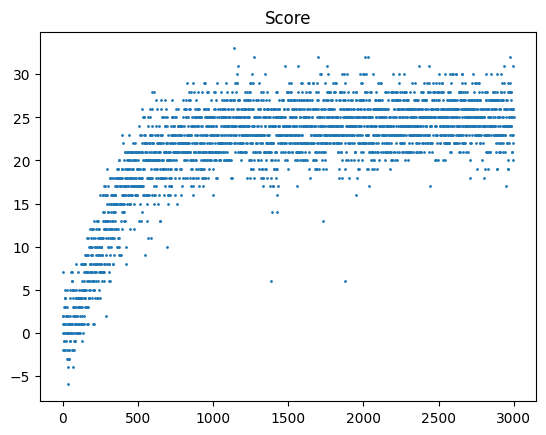

In [47]:
score = np.sum(reward_history, axis=-1)
# plt.plot(score)
plt.scatter(list(range(len(score))), score, s=1)
plt.title('Score')

In [48]:
# plt.plot(reward_history)

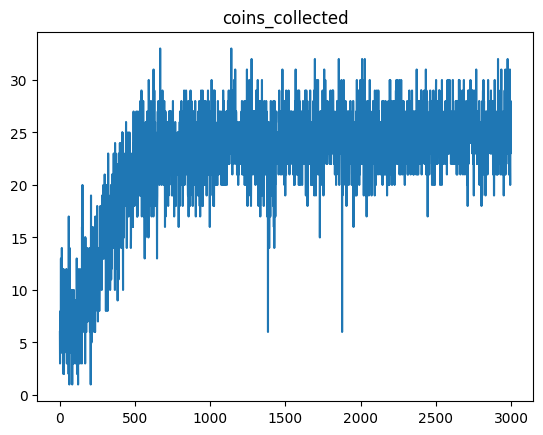

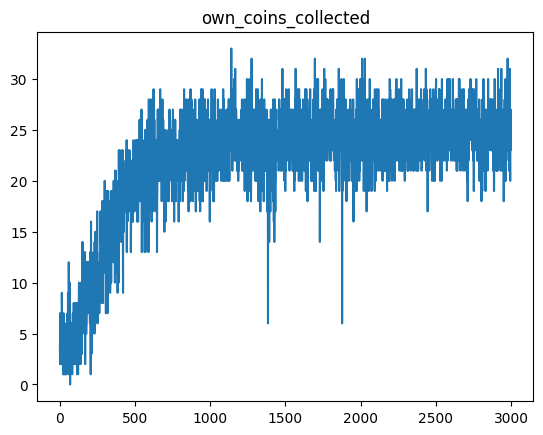

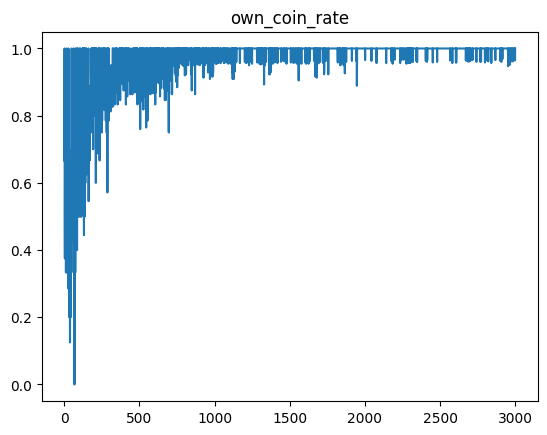

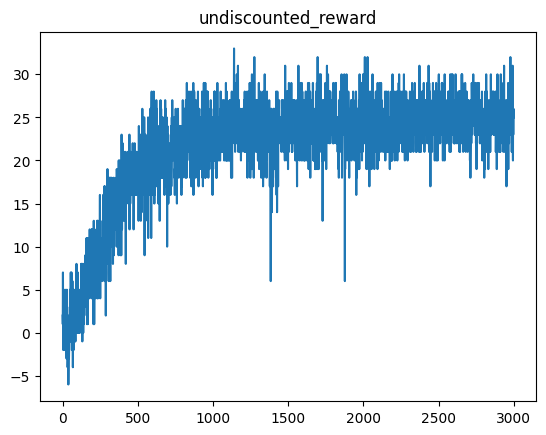

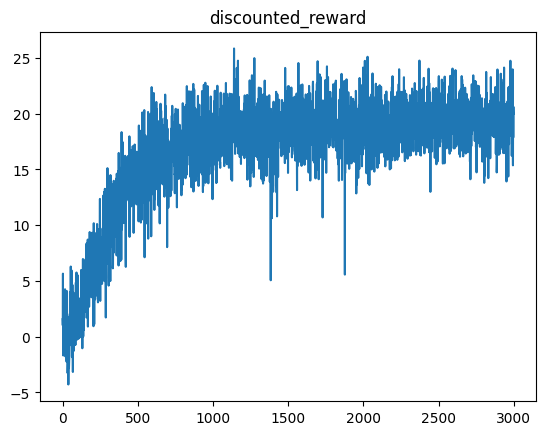

In [49]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)